# install libraries

In [ ]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

# Import helper libraries

In [1]:
from fosforio import snowflake
from fosforml import *
from fosforml.constants import MLModelFlavours
from fosforio import get_dataframe
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

%matplotlib inline

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


/tmp/pip_packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Matplotlib created a temporary cache directory at /tmp/matplotlib-k8ft0qmr because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# connect to snowflake

In [2]:
snowflake.get_connection(connection_name="TTH_REV_OPT_CXN")
data = get_dataframe("BOOKINGS_TRANSFORMED")
data

Connection object created: <snowflake.connector.connection.SnowflakeConnection object at 0x7ff18cd7c820>
Please close the connection after use!
Reading dataframe from snowflake native connector


,ARRIVAL_DATE_TRANSFORMED,RESERVATION_STATUS_DATE_TRANSFORMED,HOTEL,IS_CANCELED,LEAD_TIME,ARRIVAL_DATE_YEAR,MONTH,ARRIVAL_DATE_WEEK_NUMBER,ARRIVAL_DATE_DAY_OF_MONTH,EXPECTED_ARRIVAL_DATE,RESERVATION_STATUS,RESERVATION_STATUS_DATE,TOTAL_STAY_NIGHTS,TALLY_DAYS,STAYS_IN_WEEKEND_NIGHTS,STAYS_IN_WEEK_NIGHTS,ADULTS,CHILDREN,BABIES,TOTAL_GUESTS,AVG_ROOMS_PER_NIGHT,TOTAL_ROOM_NIGHTS,MEAL,COUNTRY,MARKET_SEGMENT,DISTRIBUTION_CHANNEL,PREVIOUS_CANCELLATIONS,PREVIOUS_BOOKINGS_NOT_CANCELED,RESERVED_ROOM_TYPE,ASSIGNED_ROOM_TYPE,DEPOSIT_TYPE,DAYS_IN_WAITING_LIST,CUSTOMER_TYPE,ADR
0,2021-07-16,2020-10-17,City Hotel,1,272,2021,7,29,16,16-07-2021,Canceled,17-10-2020,2,0.272,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
1,2021-08-20,2020-10-17,City Hotel,1,307,2021,8,34,20,20-08-2021,Canceled,17-10-2020,2,0.307,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
2,2021-07-02,2020-10-17,City Hotel,1,258,2021,7,27,2,02-07-2021,Canceled,17-10-2020,2,0.258,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
3,2021-08-20,2020-10-17,City Hotel,1,307,2021,8,34,20,20-08-2021,Canceled,17-10-2020,2,0.307,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
4,2021-07-23,2020-10-17,City Hotel,1,279,2021,7,30,23,23-07-2021,Canceled,17-10-2020,2,0.279,0,2,2,0,0,2,1,2,BB,PRT,Groups,TA/TO,1,0,A,A,No Deposit,0,Transient.Party,62.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109706,2023-08-24,2023-09-10,Resort Hotel,0,269,2023,8,34,24,24-08-2023,Check.Out,10-09-2023,17,17.000,4,13,2,0,0,2,1,17,BB,GBR,Offline TA/TO,TA/TO,0,0,D,D,No Deposit,0,Contract,84.80
109707,2023-08-31,2023-09-10,Resort Hotel,0,212,2023,8,35,31,31-08-2023,Check.Out,10-09-2023,10,10.000,2,8,2,1,0,3,1,10,BB,GBR,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,89.75
109708,2023-08-29,2023-09-12,Resort Hotel,0,204,2023,8,35,29,29-08-2023,Check.Out,12-09-2023,14,14.000,4,10,2,0,0,2,1,14,BB,IRL,Direct,Direct,0,0,E,E,No Deposit,0,Transient,153.57
109709,2023-08-31,2023-09-14,Resort Hotel,0,161,2023,8,35,31,31-08-2023,Check.Out,14-09-2023,14,14.000,4,10,2,0,0,2,1,14,HB,DEU,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,99.06


In [3]:
data.columns = [x.lower() for x in data.columns]

In [4]:
data.columns

Index(['arrival_date_transformed', 'reservation_status_date_transformed',
       'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'expected_arrival_date', 'reservation_status',
       'reservation_status_date', 'total_stay_nights', 'tally_days',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'total_guests', 'avg_rooms_per_night', 'total_room_nights',
       'meal', 'country', 'market_segment', 'distribution_channel',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr'],
      dtype='object')

# removing Canceletions and no-shows and keep City hotel data only


In [5]:
df = data[(data['is_canceled'] == 0) & (data['reservation_status'] !='No-Show')] 
df

,arrival_date_transformed,reservation_status_date_transformed,hotel,is_canceled,lead_time,arrival_date_year,month,arrival_date_week_number,arrival_date_day_of_month,expected_arrival_date,reservation_status,reservation_status_date,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr
2388,2021-07-01,2021-07-02,Resort Hotel,0,0,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,2,0,0,2,1,1,BB,FRA,Corporate,Corporate,0,0,A,G,No Deposit,0,Transient,107.42
2410,2021-07-01,2021-07-02,Resort Hotel,0,1,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,PRT,Corporate,Corporate,0,4,A,B,No Deposit,0,Transient,134.00
2425,2021-07-01,2021-07-02,Resort Hotel,0,2,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,PRT,Online TA,TA/TO,0,1,A,C,No Deposit,0,Transient,4.00
2427,2021-07-01,2021-07-02,Resort Hotel,0,4,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,PRT,Corporate,Corporate,0,4,A,C,No Deposit,0,Transient,134.00
2561,2021-07-01,2021-07-02,Resort Hotel,0,13,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,GBR,Corporate,Corporate,0,0,A,A,No Deposit,0,Transient,75.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109706,2023-08-24,2023-09-10,Resort Hotel,0,269,2023,8,34,24,24-08-2023,Check.Out,10-09-2023,17,17.0,4,13,2,0,0,2,1,17,BB,GBR,Offline TA/TO,TA/TO,0,0,D,D,No Deposit,0,Contract,84.80
109707,2023-08-31,2023-09-10,Resort Hotel,0,212,2023,8,35,31,31-08-2023,Check.Out,10-09-2023,10,10.0,2,8,2,1,0,3,1,10,BB,GBR,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,89.75
109708,2023-08-29,2023-09-12,Resort Hotel,0,204,2023,8,35,29,29-08-2023,Check.Out,12-09-2023,14,14.0,4,10,2,0,0,2,1,14,BB,IRL,Direct,Direct,0,0,E,E,No Deposit,0,Transient,153.57
109709,2023-08-31,2023-09-14,Resort Hotel,0,161,2023,8,35,31,31-08-2023,Check.Out,14-09-2023,14,14.0,4,10,2,0,0,2,1,14,HB,DEU,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,99.06


In [6]:
df.groupby(['hotel','market_segment','reserved_room_type']).agg({'adr':'mean','reservation_status_date_transformed':'count'})


adr  \
hotel        market_segment reserved_room_type               
City Hotel   Aviation       A                    96.503608   
                            D                   107.713951   
                            E                   159.250000   
             Complementary  A                    45.840909   
                            D                    25.000000   
                            E                    55.000000   
             Corporate      A                    80.056789   
                            D                   100.689130   
                            E                   114.798295   
             Direct         A                   107.756930   
                            D                   132.383522   
                            E                   164.454444   
             Groups         A                    86.892940   
                            D                    87.340441   
                            E                    80.000000   
             Offline TA/TO  A                    91.273987   
                            D                    90.301959   
                            E                   133.371644   
             Online TA      A                   106.477667   
                            D                   136.476930   
                            E                   169.355059   
Resort Hotel Complementary  A                    21.226923   
                            D                    41.216667   
                            E                     7.333333   
             Corporate      A                    49.700175   
                            D                    67.398478   
                            E                    61.588545   
             Direct         A                    84.610434   
                            D                   116.982329   
                            E                   118.980300   
             Groups         A                    67.339807   
                            D                    74.881529   
                            E                    87.092028   
             Offline TA/TO  A                    64.219800   
                            D                    85.303927   
                            E                    97.511393   
             Online TA      A                    90.874218   
                            D                   113.257346   
                            E                   117.962164   

                                                reservation_status_date_transformed  
hotel        market_segment reserved_room_type                                       
City Hotel   Aviation       A                                                    97  
                            D                                                    81  
                            E                                                     2  
             Complementary  A                                                    22  
                            D                                                     4  
                            E                                                     2  
             Corporate      A                                                  2074  
                            D                                                   138  
                            E                                                    88  
             Direct         A                                                  3147  
                            D                                                   900  
                            E                                                   405  
             Groups         A                                                  4132  
                            D                                                    68  
                            E                                                     2  
             Offline TA/TO  A                     

In [7]:
data = df[(df.market_segment != 'Complementary') ]
data = data[(data.reserved_room_type == 'A') |(data.reserved_room_type == 'D') | (data.reserved_room_type == 'E')]
data.reserved_room_type.value_counts()


reserved_room_type
A    50872
D    12855
E     4486
Name: count, dtype: int64

In [ ]:
hotel	room_type	rns
City Hotel	A	460
City Hotel	D	135
City Hotel	E	30
Resort Hotel	A	360
Resort Hotel	D	125
Resort Hotel	E	100

In [18]:
def update_values(row):
    if row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'A':
        return 460
    elif row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'D':
        return 135
    elif row['hotel'] == 'City Hotel' and row['reserved_room_type'] == 'E':
        return 30
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'A':
        return 360
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'D':
        return 125
    elif row['hotel'] == 'Resort Hotel' and row['reserved_room_type'] == 'E':
        return 100
    else:
        pass

In [20]:
data['room_limit'] = data.apply(update_values, axis=1)
data

,arrival_date_transformed,reservation_status_date_transformed,hotel,is_canceled,lead_time,arrival_date_year,month,arrival_date_week_number,arrival_date_day_of_month,expected_arrival_date,reservation_status,reservation_status_date,total_stay_nights,tally_days,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_guests,avg_rooms_per_night,total_room_nights,meal,country,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,room_limit
2388,2021-07-01,2021-07-02,Resort Hotel,0,0,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,2,0,0,2,1,1,BB,FRA,Corporate,Corporate,0,0,A,G,No Deposit,0,Transient,107.42,360
2410,2021-07-01,2021-07-02,Resort Hotel,0,1,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,PRT,Corporate,Corporate,0,4,A,B,No Deposit,0,Transient,134.00,360
2425,2021-07-01,2021-07-02,Resort Hotel,0,2,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,PRT,Online TA,TA/TO,0,1,A,C,No Deposit,0,Transient,4.00,360
2427,2021-07-01,2021-07-02,Resort Hotel,0,4,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,PRT,Corporate,Corporate,0,4,A,C,No Deposit,0,Transient,134.00,360
2561,2021-07-01,2021-07-02,Resort Hotel,0,13,2021,7,27,1,01-07-2021,Check.Out,02-07-2021,1,1.0,0,1,1,0,0,1,1,1,BB,GBR,Corporate,Corporate,0,0,A,A,No Deposit,0,Transient,75.00,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109706,2023-08-24,2023-09-10,Resort Hotel,0,269,2023,8,34,24,24-08-2023,Check.Out,10-09-2023,17,17.0,4,13,2,0,0,2,1,17,BB,GBR,Offline TA/TO,TA/TO,0,0,D,D,No Deposit,0,Contract,84.80,125
109707,2023-08-31,2023-09-10,Resort Hotel,0,212,2023,8,35,31,31-08-2023,Check.Out,10-09-2023,10,10.0,2,8,2,1,0,3,1,10,BB,GBR,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,89.75,360
109708,2023-08-29,2023-09-12,Resort Hotel,0,204,2023,8,35,29,29-08-2023,Check.Out,12-09-2023,14,14.0,4,10,2,0,0,2,1,14,BB,IRL,Direct,Direct,0,0,E,E,No Deposit,0,Transient,153.57,100
109709,2023-08-31,2023-09-14,Resort Hotel,0,161,2023,8,35,31,31-08-2023,Check.Out,14-09-2023,14,14.0,4,10,2,0,0,2,1,14,HB,DEU,Offline TA/TO,TA/TO,0,0,A,A,No Deposit,0,Transient,99.06,360


In [21]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 68213 entries, 2388 to 109710
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   arrival_date_transformed             68213 non-null  object 
 1   reservation_status_date_transformed  68213 non-null  object 
 2   hotel                                68213 non-null  object 
 3   is_canceled                          68213 non-null  int8   
 4   lead_time                            68213 non-null  int16  
 5   arrival_date_year                    68213 non-null  int16  
 6   month                                68213 non-null  int8   
 7   arrival_date_week_number             68213 non-null  int8   
 8   arrival_date_day_of_month            68213 non-null  int8   
 9   expected_arrival_date                68213 non-null  object 
 10  reservation_status                   68213 non-null  object 
 11  reservation_status_date      

In [22]:
hotels = data['hotel'].unique()
room_types = data['reserved_room_type'].unique()

In [25]:
data['total_rns'] = data['stays_in_week_nights'] + data['stays_in_weekend_nights']
data_to_transform = data[['hotel','reserved_room_type','arrival_date_transformed','total_rns','adr', 'room_limit']]
data_to_transform

,hotel,reserved_room_type,arrival_date_transformed,total_rns,adr,room_limit
2388,Resort Hotel,A,2021-07-01,1,107.42,360
2410,Resort Hotel,A,2021-07-01,1,134.00,360
2425,Resort Hotel,A,2021-07-01,1,4.00,360
2427,Resort Hotel,A,2021-07-01,1,134.00,360
2561,Resort Hotel,A,2021-07-01,1,75.00,360
...,...,...,...,...,...,...
109706,Resort Hotel,D,2023-08-24,17,84.80,125
109707,Resort Hotel,A,2023-08-31,10,89.75,360
109708,Resort Hotel,E,2023-08-29,14,153.57,100
109709,Resort Hotel,A,2023-08-31,14,99.06,360


In [ ]:
import os
from snowflake.snowpark.session import Session
user = os.getenv("user")
warehouse = os.getenv("warehouse")
schema= os.getenv("schema")
database = os.getenv("database")
role =  os.getenv("role")
account =  os.getenv("account")
password= os.getenv("password")

connection_params = dict(user=user, 
                         password=password, 
                         account=account, 
                         warehouse=warehouse, 
                         database=database,
                         schema=schema, 
                         role=role)

session = Session.builder.configs(connection_params).create()

session.sql('use warehouse {};'.format(warehouse)).collect()

session.sql('use database {};'.format(database)).collect()

session.sql('use schema {}.{};'.format(database, schema)).collect()

# Create a new dataframe to store the data by stay date

In [26]:
expanded_df = pd.DataFrame()

for _, row in data.iterrows():
    num_stay_dates = row['total_rns']
    try:
        # Create a row for each stay date
        expanded_booking = pd.DataFrame({
            'hotel': row['hotel'],
            'room_type': row['reserved_room_type'], 
            'arrival_date': pd.date_range(start=row['expected_arrival_date'], periods=num_stay_dates),
            'total_rns': 1,
            'adr': row['adr'],
            'room_limit': row['room_limit']
        })
        
        # Append the stay date information to the new dataframe
        expanded_df = pd.concat([expanded_df, expanded_booking], ignore_index=True)
    except ValueError as e:
        print(f"Error processing booking for {row['hotel']} on {row['expected_arrival_date']} : {num_stay_dates} {e}")

Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 1 day is out of range for month
Error processing booking for City Hotel on 29-02-2022 : 2 day is out of range for month
Error processing booking for Resort Hotel on 29-02-2022 : 2 day is out of range for month
Error processing booking

# Sort the final dataframe by date

In [27]:
expanded_df = expanded_df.sort_values('arrival_date')
expanded_df = expanded_df.reset_index(drop=True)
expanded_df

,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,Resort Hotel,A,2021-01-07,1,107.42,360
1,City Hotel,A,2021-01-07,1,101.50,460
2,Resort Hotel,A,2021-01-07,1,62.00,360
3,City Hotel,A,2021-01-07,1,101.50,460
4,City Hotel,A,2021-01-07,1,80.00,460
...,...,...,...,...,...,...
232598,Resort Hotel,E,2023-12-18,1,158.00,100
232599,Resort Hotel,A,2023-12-18,1,40.95,360
232600,Resort Hotel,A,2023-12-18,1,169.00,360
232601,Resort Hotel,E,2023-12-19,1,158.00,100


In [28]:
expanded_df['adr']= np.round(expanded_df['adr'], 2)

expanded_df


,hotel,room_type,arrival_date,total_rns,adr,room_limit
0,Resort Hotel,A,2021-01-07,1,107.42,360
1,City Hotel,A,2021-01-07,1,101.50,460
2,Resort Hotel,A,2021-01-07,1,62.00,360
3,City Hotel,A,2021-01-07,1,101.50,460
4,City Hotel,A,2021-01-07,1,80.00,460
...,...,...,...,...,...,...
232598,Resort Hotel,E,2023-12-18,1,158.00,100
232599,Resort Hotel,A,2023-12-18,1,40.95,360
232600,Resort Hotel,A,2023-12-18,1,169.00,360
232601,Resort Hotel,E,2023-12-19,1,158.00,100


# Building seasonality

In [29]:
import holidays
holiday_dates = holidays.CountryHoliday('PT', years=[2020,2021,2022,2023])
holidays = {
    expected_arrival_date: name
    for expected_arrival_date, name in holiday_dates.items()
    if name in ['Ano Novo', 'Páscoa', 'Dia de Natal']
}

# rename holiday columns

In [30]:
expanded_df = expanded_df.rename({'Ano Novo':'new_year','Páscoa':'easter','Dia de Natal':'christmas'},axis=1)

In [31]:
def generate_holiday_dates(start_year, end_year):
    holidays = {}
    for year in range(start_year, end_year + 1):
        holidays[datetime.date(year, 1, 1)] = 'new_year'
        easter_date = easter(year)
        holidays[easter_date] = 'easter'
        holidays[datetime.date(year, 12, 25)] = 'christmas'
    return holidays

holidays = generate_holiday_dates(2020, 2023)


In [32]:
holidays

{datetime.date(2020, 1, 1): 'new_year',
 datetime.date(2020, 4, 12): 'easter',
 datetime.date(2020, 12, 25): 'christmas',
 datetime.date(2021, 1, 1): 'new_year',
 datetime.date(2021, 4, 4): 'easter',
 datetime.date(2021, 12, 25): 'christmas',
 datetime.date(2022, 1, 1): 'new_year',
 datetime.date(2022, 4, 17): 'easter',
 datetime.date(2022, 12, 25): 'christmas',
 datetime.date(2023, 1, 1): 'new_year',
 datetime.date(2023, 4, 9): 'easter',
 datetime.date(2023, 12, 25): 'christmas'}

In [33]:
# Define pre and post ranges for each holiday
pre_range_offset = {'new_year': relativedelta(days=-1),
                    'easter': relativedelta(days=-2),
                    'christmas': relativedelta(days=-3)}

post_range_offset = {'new_year': relativedelta(days=1),
                     'easter': relativedelta(days=2),
                     'christmas': relativedelta(days=3)}

In [34]:
# Create new columns for each holiday
for holiday in holidays.values():
    expanded_df[holiday] = 0
 
 # Set the holiday columns to 1 for matching dates
for arrival_date, name in holidays.items():
    expanded_df.loc[expanded_df['arrival_date'] == arrival_date, name] = 1

    # Set the holiday columns to 1 for pre and post dates
    pre_offset = pre_range_offset.get(name)
    if pre_offset:
        pre_date = pd.to_datetime(arrival_date) + pre_offset
        expanded_df.loc[expanded_df['arrival_date'] == pre_date.strftime('%Y-%m-%d'), name] = 1

    post_offset = post_range_offset.get(name)
    if post_offset:
        post_date = pd.to_datetime(arrival_date) + post_offset
        expanded_df.loc[expanded_df['arrival_date'] == post_date.strftime('%Y-%m-%d'), name] = 1

In [35]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,room_limit,new_year,easter,christmas
0,Resort Hotel,A,2021-01-07,1,107.42,360,0,0,0
1,City Hotel,A,2021-01-07,1,101.50,460,0,0,0
2,Resort Hotel,A,2021-01-07,1,62.00,360,0,0,0
3,City Hotel,A,2021-01-07,1,101.50,460,0,0,0
4,City Hotel,A,2021-01-07,1,80.00,460,0,0,0


In [37]:
# Add dow, month to data
expanded_df['dow'] = expanded_df.arrival_date.dt.strftime('%A')
expanded_df['month'] = expanded_df.arrival_date.dt.strftime('%B')

In [38]:
##check
expanded_df.head()

,hotel,room_type,arrival_date,total_rns,adr,room_limit,new_year,easter,christmas,dow,month
0,Resort Hotel,A,2021-01-07,1,107.42,360,0,0,0,Thursday,January
1,City Hotel,A,2021-01-07,1,101.50,460,0,0,0,Thursday,January
2,Resort Hotel,A,2021-01-07,1,62.00,360,0,0,0,Thursday,January
3,City Hotel,A,2021-01-07,1,101.50,460,0,0,0,Thursday,January
4,City Hotel,A,2021-01-07,1,80.00,460,0,0,0,Thursday,January


In [39]:
expanded_df.shape

(232603, 11)

In [40]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232603 entries, 0 to 232602
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   hotel         232603 non-null  object        
 1   room_type     232603 non-null  object        
 2   arrival_date  232603 non-null  datetime64[ns]
 3   total_rns     232603 non-null  int64         
 4   adr           232603 non-null  float64       
 5   room_limit    232603 non-null  int64         
 6   new_year      232603 non-null  int64         
 7   easter        232603 non-null  int64         
 8   christmas     232603 non-null  int64         
 9   dow           232603 non-null  object        
 10  month         232603 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 19.5+ MB


In [41]:
expanded_df[expanded_df['easter'] == 0]

,hotel,room_type,arrival_date,total_rns,adr,room_limit,new_year,easter,christmas,dow,month
0,Resort Hotel,A,2021-01-07,1,107.42,360,0,0,0,Thursday,January
1,City Hotel,A,2021-01-07,1,101.50,460,0,0,0,Thursday,January
2,Resort Hotel,A,2021-01-07,1,62.00,360,0,0,0,Thursday,January
3,City Hotel,A,2021-01-07,1,101.50,460,0,0,0,Thursday,January
4,City Hotel,A,2021-01-07,1,80.00,460,0,0,0,Thursday,January
...,...,...,...,...,...,...,...,...,...,...,...
232598,Resort Hotel,E,2023-12-18,1,158.00,100,0,0,0,Monday,December
232599,Resort Hotel,A,2023-12-18,1,40.95,360,0,0,0,Monday,December
232600,Resort Hotel,A,2023-12-18,1,169.00,360,0,0,0,Monday,December
232601,Resort Hotel,E,2023-12-19,1,158.00,100,0,0,0,Tuesday,December


In [43]:
expanded_df['adr'] = np.round(expanded_df['adr'], 2)
expanded_df

,hotel,room_type,arrival_date,total_rns,adr,room_limit,new_year,easter,christmas,dow,month
0,Resort Hotel,A,2021-01-07,1,107.42,360,0,0,0,Thursday,January
1,City Hotel,A,2021-01-07,1,101.50,460,0,0,0,Thursday,January
2,Resort Hotel,A,2021-01-07,1,62.00,360,0,0,0,Thursday,January
3,City Hotel,A,2021-01-07,1,101.50,460,0,0,0,Thursday,January
4,City Hotel,A,2021-01-07,1,80.00,460,0,0,0,Thursday,January
...,...,...,...,...,...,...,...,...,...,...,...
232598,Resort Hotel,E,2023-12-18,1,158.00,100,0,0,0,Monday,December
232599,Resort Hotel,A,2023-12-18,1,40.95,360,0,0,0,Monday,December
232600,Resort Hotel,A,2023-12-18,1,169.00,360,0,0,0,Monday,December
232601,Resort Hotel,E,2023-12-19,1,158.00,100,0,0,0,Tuesday,December


# Non holidays dataset

In [44]:
non_holidays = expanded_df[expanded_df[['new_year', 'easter', 'christmas']].sum(axis=1) == 0]

non_holidays.head()

,hotel,room_type,arrival_date,total_rns,adr,room_limit,new_year,easter,christmas,dow,month
0,Resort Hotel,A,2021-01-07,1,107.42,360,0,0,0,Thursday,January
1,City Hotel,A,2021-01-07,1,101.50,460,0,0,0,Thursday,January
2,Resort Hotel,A,2021-01-07,1,62.00,360,0,0,0,Thursday,January
3,City Hotel,A,2021-01-07,1,101.50,460,0,0,0,Thursday,January
4,City Hotel,A,2021-01-07,1,80.00,460,0,0,0,Thursday,January


In [45]:
non_holidays.shape

(229545, 11)

In [46]:
daily_rns= non_holidays.groupby(['arrival_date','dow','month', 'hotel', 'room_type']).agg({'room_limit': 'mean', 'total_rns':'sum'}).reset_index() # ge total stays per day

daily_rns = daily_rns.groupby(['dow','month', 'hotel', 'room_type']).agg({'room_limit': 'mean','total_rns':['sum','mean','median']}).reset_index() # get Rns metrics by Dow & Month

daily_rns.columns = ['_'.join(col) for col in daily_rns.columns] #remove multi level column
daily_rns

,dow_,month_,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,City Hotel,A,460.0,1093,109.300000,133.5
1,Friday,April,City Hotel,D,135.0,274,30.444444,31.0
2,Friday,April,City Hotel,E,30.0,35,4.375000,4.0
3,Friday,April,Resort Hotel,A,360.0,644,71.555556,75.0
4,Friday,April,Resort Hotel,D,125.0,251,25.100000,25.5
...,...,...,...,...,...,...,...,...
499,Wednesday,September,City Hotel,D,135.0,260,26.000000,29.5
500,Wednesday,September,City Hotel,E,30.0,26,3.714286,3.0
501,Wednesday,September,Resort Hotel,A,360.0,783,71.181818,82.0
502,Wednesday,September,Resort Hotel,D,125.0,380,31.666667,34.5


In [47]:
adr_frequency = non_holidays.groupby(['dow','month','adr', 'hotel', 'room_type']).agg({'room_limit': 'mean','total_rns':'sum'})
adr_frequency.reset_index(inplace=True)

In [48]:
adr_frequency

,dow,month,adr,hotel,room_type,room_limit,total_rns
0,Friday,April,4.00,Resort Hotel,A,360.0,1
1,Friday,April,6.00,City Hotel,E,30.0,1
2,Friday,April,12.00,City Hotel,A,460.0,1
3,Friday,April,12.00,City Hotel,D,135.0,1
4,Friday,April,19.09,City Hotel,D,135.0,1
...,...,...,...,...,...,...,...
102879,Wednesday,September,236.00,Resort Hotel,A,360.0,1
102880,Wednesday,September,237.45,Resort Hotel,A,360.0,1
102881,Wednesday,September,253.00,Resort Hotel,D,125.0,1
102882,Wednesday,September,273.09,Resort Hotel,A,360.0,1


In [49]:
merged_df = pd.merge(adr_frequency, daily_rns,how='left',left_on=['dow','month', 'hotel', 'room_type'], right_on=['dow_','month_', 'hotel_', 'room_type_'],suffixes=('_act', '_tot'))

merged_df = merged_df.drop(['dow_','month_'],axis=1)

merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,Friday,April,4.00,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,644,71.555556,75.0
1,Friday,April,6.00,City Hotel,E,30.0,1,City Hotel,E,30.0,35,4.375000,4.0
2,Friday,April,12.00,City Hotel,A,460.0,1,City Hotel,A,460.0,1093,109.300000,133.5
3,Friday,April,12.00,City Hotel,D,135.0,1,City Hotel,D,135.0,274,30.444444,31.0
4,Friday,April,19.09,City Hotel,D,135.0,1,City Hotel,D,135.0,274,30.444444,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102879,Wednesday,September,236.00,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,783,71.181818,82.0
102880,Wednesday,September,237.45,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,783,71.181818,82.0
102881,Wednesday,September,253.00,Resort Hotel,D,125.0,1,Resort Hotel,D,125.0,380,31.666667,34.5
102882,Wednesday,September,273.09,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,783,71.181818,82.0


In [50]:
merged_df['probability'] = merged_df['total_rns']/merged_df['total_rns_sum']

In [51]:
merged_df['expected_rns'] = merged_df['probability'] * merged_df['total_rns_median']

In [52]:
merged_df = merged_df.sort_values(by=['dow', 'month', 'adr'], ascending=[True, True, False])

In [53]:
merged_df['expected_demand']=merged_df.groupby(['dow', 'month'])['expected_rns'].cumsum()

In [54]:
merged_df['expected_rev'] = merged_df['adr']* merged_df['expected_demand']

In [55]:
merged_df['expected_rev'] = merged_df['adr']* merged_df['expected_demand']

<Axes: xlabel='adr'>

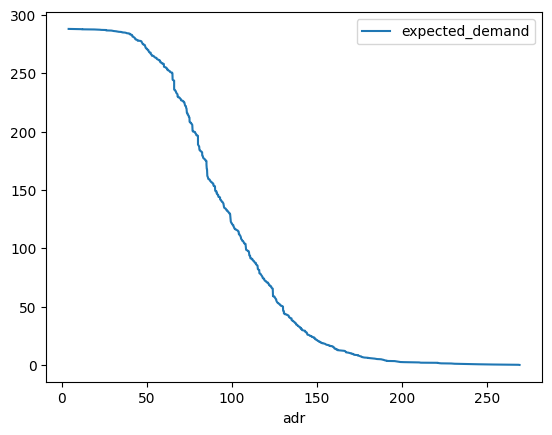

In [56]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_demand', kind='line')

<Axes: xlabel='adr'>

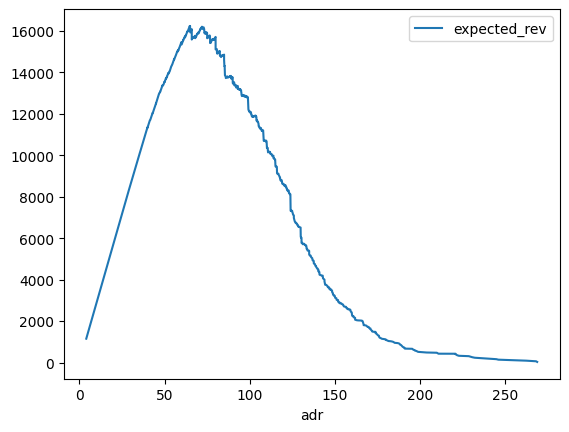

In [57]:
merged_df[(merged_df.dow == 'Friday') & (merged_df.month =='April')].plot(x='adr', y='expected_rev', kind='line')

In [58]:
merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median,probability,expected_rns,expected_demand,expected_rev
1024,Friday,April,269.00,City Hotel,E,30.0,1,City Hotel,E,30.0,35,4.375000,4.0,0.028571,0.114286,0.114286,30.742857
1023,Friday,April,268.33,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,644,71.555556,75.0,0.001553,0.116460,0.230745,61.915898
1022,Friday,April,262.60,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,644,71.555556,75.0,0.001553,0.116460,0.347205,91.176025
1021,Friday,April,253.50,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,644,71.555556,75.0,0.001553,0.116460,0.463665,117.538975
1020,Friday,April,246.20,Resort Hotel,D,125.0,1,Resort Hotel,D,125.0,251,25.100000,25.5,0.003984,0.101594,0.565258,139.166574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101623,Wednesday,September,26.00,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,783,71.181818,82.0,0.001277,0.104725,320.071890,8321.869147
101622,Wednesday,September,10.00,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,783,71.181818,82.0,0.001277,0.104725,320.176616,3201.766157
101621,Wednesday,September,6.00,City Hotel,A,460.0,1,City Hotel,A,460.0,1372,124.727273,150.0,0.000729,0.109329,320.285945,1921.715671
101620,Wednesday,September,4.00,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,783,71.181818,82.0,0.001277,0.104725,320.390671,1281.562682


In [59]:
from scipy.optimize import curve_fit

# Define the demand curve function
def demand_curve(x, a, b, c, d, max_demand):
    demand = a * np.exp(-b * x) + c
    demand = np.where(x <= max_demand, np.minimum(demand, max_demand), demand)
    return demand + d


In [60]:
x_data = merged_df['adr'].values
y_data = merged_df['expected_demand'].values


initial_guess = [1, 0.01, 1, 1, 100]
bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)

a_fit, b_fit, c_fit ,d_fit,max_demand= params

In [61]:
predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)

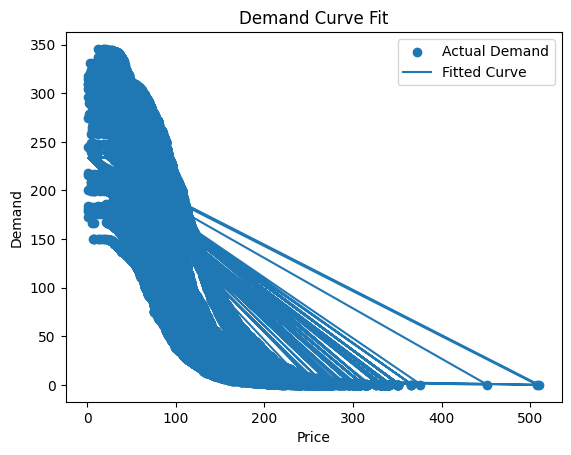

In [62]:
plt.scatter(x_data, y_data, label='Actual Demand')
plt.plot(x_data, predicted_demand, label='Fitted Curve')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand Curve Fit')
plt.show()

In [63]:
def revenue(price):
    return price * demand_curve(price, a_fit, b_fit,c_fit,d_fit,max_demand)

In [64]:
objective = lambda price: -revenue(price)
from scipy.optimize import minimize_scalar

result = minimize_scalar(objective, bounds=(60, 180), method='bounded')
optimal_price = result.x
max_revenue = -result.fun
room_sold = demand_curve(optimal_price, a_fit, b_fit,c_fit,d_fit,max_demand)

In [65]:
print(f"The optimal price to maximize revenue: ${optimal_price}")
print(f"The maximum revenue achievable: ${max_revenue}")
print(f"The expected number of rooms to sell: {room_sold}")

The optimal price to maximize revenue: $60.00000518697956
The maximum revenue achievable: $13895.757686321656
The expected number of rooms to sell: 231.59594141730403


In [66]:
demand_to_price(50,a_fit,b_fit,c_fit,d_fit,max_demand, optimal_price)

149.25001837860677

In [129]:
results = pd.DataFrame(columns=['month', 'hotel','room_limit', 'room_type', 'dow', 'optimal_rate', 'expected_rn','expected_rev','optimal_rate_lim_inv'])

In [69]:
months = merged_df.month.unique()
dow = merged_df.dow.unique()

In [91]:
merged_df

,dow,month,adr,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median,probability,expected_rns,expected_demand,expected_rev
1024,Friday,April,269.00,City Hotel,E,30.0,1,City Hotel,E,30.0,35,4.375000,4.0,0.028571,0.114286,0.114286,30.742857
1023,Friday,April,268.33,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,644,71.555556,75.0,0.001553,0.116460,0.230745,61.915898
1022,Friday,April,262.60,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,644,71.555556,75.0,0.001553,0.116460,0.347205,91.176025
1021,Friday,April,253.50,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,644,71.555556,75.0,0.001553,0.116460,0.463665,117.538975
1020,Friday,April,246.20,Resort Hotel,D,125.0,1,Resort Hotel,D,125.0,251,25.100000,25.5,0.003984,0.101594,0.565258,139.166574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101623,Wednesday,September,26.00,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,783,71.181818,82.0,0.001277,0.104725,320.071890,8321.869147
101622,Wednesday,September,10.00,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,783,71.181818,82.0,0.001277,0.104725,320.176616,3201.766157
101621,Wednesday,September,6.00,City Hotel,A,460.0,1,City Hotel,A,460.0,1372,124.727273,150.0,0.000729,0.109329,320.285945,1921.715671
101620,Wednesday,September,4.00,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,783,71.181818,82.0,0.001277,0.104725,320.390671,1281.562682


In [ ]:
#Create a loop to observe if our demand curve fits properly to each demand month and dow


for month in months:
    for day in dow:
        
        print(month,day)
        #get data
        data = merged_df[(merged_df.dow == day) & (merged_df.month ==month)].reset_index()
        
        #remove outlier
        mean = data.adr.mean()
        std_dev = data.adr.std()
       

        # calculate z-scores
        data['z_scores'] = np.abs((data.adr - mean) / std_dev)
        
        #filter out outliers
        data = data[data.z_scores <=2]
        
        ## Fit Demand curve
        x_data = data['adr'].values
        y_data = data['expected_demand'].values
        
        # Try except expression to ensure we get no errors when fitting the demand curve due to our initial guess
        try:
            initial_guess = [1, 0.01, 1, 1,data['total_rns_median'].values[0] ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

        # Fit the demand curve to the data
            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        except:
            if month =='January':
                
                initial_guess = [1, 0.01, 1, 1,40 ]
            else:
                initial_guess = [1, 0.01, 1, 1,50 ]
            bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

        # Fit the demand curve to the data
            params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
        
        # Extract the fitted parameters
        a_fit, b_fit, c_fit ,d_fit,max_demand= params
        
        #visually explore if the demand curve fits the data
        predicted_demand = demand_curve(x_data, a_fit, b_fit,c_fit,d_fit,max_demand)
        
        plt.scatter(x_data, y_data, label='Actual Demand')
        plt.plot(x_data, predicted_demand, label='Fitted Curve')
        plt.xlabel('Price')
        plt.ylabel('Demand')
        plt.legend()
        plt.title('Demand Curve Fit')
        plt.show()

In [76]:
from scipy.optimize import brentq

def demand_to_price(num_rooms, a, b, c, d, max_demand):
    def root_func(x):
        return num_rooms - (a * np.exp(-b * x) + c)

    try:
        price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    except ValueError:
        # Fallback to default price if no root is found
        price_range=(0, 200)
        price = np.random.uniform(*price_range)

    return price

# from scipy.optimize import brentq

# def demand_to_price(num_rooms, a, b, c, d, max_demand):
   
#     def root_func(x):
#         return num_rooms - (a * np.exp(-b * x) + c)
    
#     # Find the price using numerical root finding
#     price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    
#     return price

In [130]:
for hotel in hotels:
    for room_type in room_types:
        for month in months:
            for day in dow:
                # Get data for the specific combination
                data_subset = merged_df[(merged_df['dow'] == day) & 
                                        (merged_df['hotel'] == hotel) & 
                                        (merged_df['room_type'] == room_type) & 
                                        (merged_df['month'] == month)].reset_index()
                
                if data_subset.empty:
                    continue

                # Remove outliers
                mean = data_subset['adr'].mean()
                std_dev = data_subset['adr'].std()
                data_subset['z_scores'] = np.abs((data_subset['adr'] - mean) / std_dev)
                data_subset = data_subset[data_subset['z_scores'] <= 2]

                # Fit demand curve
                x_data = data_subset['adr'].values
                y_data = data_subset['expected_demand'].values

                try:
                    initial_guess = [1, 0.01, 1, 1, data_subset['total_rns_median'].values[0]]
                    bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])
                    maxfev = 10000  # Increase the number of maximum function evaluations
                    params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess, maxfev=maxfev)
                except RuntimeError as e:
                    print(f"Error fitting demand curve for {hotel}, {room_type}, {month}, {day}: {e}")
                    continue

                a_fit, b_fit, c_fit, d_fit, max_demand = params

                # Optimize revenue
                def revenue(price):
                    return price * demand_curve(price, a_fit, b_fit, c_fit, d_fit, max_demand)

                objective = lambda price: -revenue(price)
                optimize = minimize_scalar(objective, bounds=(45, 200), method='bounded')
                optimal_price = optimize.x
                max_revenue = -optimize.fun
                expected_rns = demand_curve(optimal_price, a_fit, b_fit, c_fit, d_fit, max_demand)

                optimal_rate_lim_inv = demand_to_price(data_subset['room_limit'].mean(), a_fit, b_fit, c_fit, d_fit, max_demand)

                new_row = pd.DataFrame({'hotel': hotel,
                                        'room_type': room_type,
                                        'room_limit': data_subset['room_limit'].mean(),
                                        'month': month,
                                        'dow': day,
                                        'optimal_rate': optimal_price,
                                        'expected_rev': max_revenue,
                                        'expected_rn': expected_rns,
                                        'optimal_rate_lim_inv': optimal_rate_lim_inv}, index=[0])
                results = pd.concat([results, new_row], ignore_index=True)


In [131]:
results

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,Resort Hotel,360.0,A,Friday,60.962989,274.229579,16717.854700,48.374455
1,April,Resort Hotel,360.0,A,Monday,56.572497,273.902838,15495.367517,43.926916
2,April,Resort Hotel,360.0,A,Saturday,60.173546,311.246745,18728.820372,53.313607
3,April,Resort Hotel,360.0,A,Sunday,58.679237,271.859424,15952.503544,45.254750
4,April,Resort Hotel,360.0,A,Thursday,62.005359,251.426284,15589.777099,44.363632
...,...,...,...,...,...,...,...,...,...
499,September,City Hotel,30.0,E,Saturday,45.000008,523.045783,23537.064176,165.172126
500,September,City Hotel,30.0,E,Sunday,45.000008,598.150160,26916.761685,157.088455
501,September,City Hotel,30.0,E,Thursday,45.000008,784.788842,35315.503805,159.502857
502,September,City Hotel,30.0,E,Tuesday,45.000008,787.161744,35422.284400,158.379180


In [ ]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Sort the dataframe by the custom order
results['month'] = pd.Categorical(results['month'], categories=month_order, ordered=True)
results['dow'] = pd.Categorical(results['dow'], categories=dow_order, ordered=True)
results = results.sort_values(['month', 'dow'])

grouped = results.groupby(['month', 'dow'])['optimal_rate'].mean().unstack()

# Create the graph
fig, ax = plt.subplots(figsize=(10, 6))
grouped.plot(ax=ax, kind='bar')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Optimal Rate')
ax.set_title('Optimal Rate by Month and Day of the Week')

# Customize the appearance (optional)
plt.legend(title='Month', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)

# Show the graph
plt.show()

In [132]:
#clean up the results
results['optimal_rate'] = results['optimal_rate'].round()
results['optimal_rate_lim_inv'] = results['optimal_rate_lim_inv'].round()

results['expected_rn'] = results['expected_rn'].round().astype(int)
results['expected_rev'] = results['expected_rev'].round()
results

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,Resort Hotel,360.0,A,Friday,61.0,274,16718.0,48.0
1,April,Resort Hotel,360.0,A,Monday,57.0,274,15495.0,44.0
2,April,Resort Hotel,360.0,A,Saturday,60.0,311,18729.0,53.0
3,April,Resort Hotel,360.0,A,Sunday,59.0,272,15953.0,45.0
4,April,Resort Hotel,360.0,A,Thursday,62.0,251,15590.0,44.0
...,...,...,...,...,...,...,...,...,...
499,September,City Hotel,30.0,E,Saturday,45.0,523,23537.0,165.0
500,September,City Hotel,30.0,E,Sunday,45.0,598,26917.0,157.0
501,September,City Hotel,30.0,E,Thursday,45.0,785,35316.0,160.0
502,September,City Hotel,30.0,E,Tuesday,45.0,787,35422.0,158.0


# Holidays

In [133]:
holidays =  expanded_df[expanded_df[['new_year', 'easter', 'christmas']].sum(axis=1) != 0]
holidays

,hotel,room_type,arrival_date,total_rns,adr,room_limit,new_year,easter,christmas,dow,month
41491,Resort Hotel,A,2021-12-22,1,64.14,360,0,0,1,Wednesday,December
41492,Resort Hotel,A,2021-12-22,1,35.16,360,0,0,1,Wednesday,December
41493,Resort Hotel,A,2021-12-22,1,35.00,360,0,0,1,Wednesday,December
41494,Resort Hotel,D,2021-12-22,1,58.00,125,0,0,1,Wednesday,December
41495,Resort Hotel,A,2021-12-22,1,42.57,360,0,0,1,Wednesday,December
...,...,...,...,...,...,...,...,...,...,...,...
179023,Resort Hotel,A,2023-04-11,1,42.11,360,0,1,0,Tuesday,April
179024,City Hotel,D,2023-04-11,1,139.50,135,0,1,0,Tuesday,April
179025,Resort Hotel,D,2023-04-11,1,123.50,125,0,1,0,Tuesday,April
179026,Resort Hotel,D,2023-04-11,1,154.50,125,0,1,0,Tuesday,April


In [134]:
unpivoted = pd.melt(holidays, id_vars=['arrival_date', 'total_rns', 'adr', 'dow', 'month', "hotel", "room_type", 'room_limit'],
                    value_vars=['new_year', 'easter', 'christmas'],
                    var_name='holiday', value_name='holiday_indicator')

In [135]:
unpivoted[unpivoted.holiday =='christmas']
unpivoted = unpivoted[unpivoted['holiday_indicator'] == 1]
unpivoted

,arrival_date,total_rns,adr,dow,month,hotel,room_type,room_limit,holiday,holiday_indicator
352,2021-12-31,1,136.50,Friday,December,Resort Hotel,A,360,new_year,1
353,2021-12-31,1,136.50,Friday,December,Resort Hotel,A,360,new_year,1
354,2021-12-31,1,136.50,Friday,December,Resort Hotel,A,360,new_year,1
355,2021-12-31,1,84.50,Friday,December,Resort Hotel,A,360,new_year,1
356,2021-12-31,1,127.27,Friday,December,Resort Hotel,D,125,new_year,1
...,...,...,...,...,...,...,...,...,...,...
8175,2022-12-28,1,93.60,Wednesday,December,City Hotel,A,460,christmas,1
8176,2022-12-28,1,48.00,Wednesday,December,Resort Hotel,A,360,christmas,1
8177,2022-12-28,1,30.96,Wednesday,December,Resort Hotel,A,360,christmas,1
8178,2022-12-28,1,59.33,Wednesday,December,Resort Hotel,A,360,christmas,1


In [136]:
holiday_adr = unpivoted.groupby(['holiday','adr','holiday_indicator', "hotel", "room_type"]).agg({'room_limit': 'mean', 'total_rns':'sum'}).reset_index()
holiday_rns = unpivoted.groupby(['arrival_date','holiday', "hotel", "room_type"]).agg({'room_limit': 'mean','total_rns':'sum'}).reset_index()
holiday_rns = holiday_rns.groupby(['holiday', "hotel", "room_type"]).agg({'room_limit': 'mean', 'total_rns':['sum','mean','median']}).reset_index()
holiday_rns.columns = ['_'.join(col) for col in holiday_rns.columns]

In [137]:
holiday_rns

,holiday_,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,christmas,City Hotel,A,460.0,332,83.000000,94.0
1,christmas,City Hotel,D,135.0,93,23.250000,17.5
2,christmas,City Hotel,E,30.0,14,4.666667,3.0
3,christmas,Resort Hotel,A,360.0,242,60.500000,59.5
4,christmas,Resort Hotel,D,125.0,95,23.750000,24.5
5,christmas,Resort Hotel,E,100.0,67,16.750000,17.0
6,easter,City Hotel,A,460.0,453,113.250000,133.5
7,easter,City Hotel,D,135.0,134,33.500000,35.5
8,easter,City Hotel,E,30.0,19,4.750000,4.0
9,easter,Resort Hotel,A,360.0,264,66.000000,60.5


In [138]:
merged_holidays = pd.merge(holiday_adr, holiday_rns,how='left',left_on=['holiday' ,'hotel', 'room_type'], right_on=['holiday_' ,'hotel_', 'room_type_'],suffixes=('_act', '_tot'))

merged_holidays.drop('holiday_',axis=1,inplace=True)

merged_holidays

,holiday,adr,holiday_indicator,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median
0,christmas,24.95,1,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,242,60.500000,59.5
1,christmas,25.00,1,Resort Hotel,A,360.0,4,Resort Hotel,A,360.0,242,60.500000,59.5
2,christmas,25.11,1,Resort Hotel,A,360.0,2,Resort Hotel,A,360.0,242,60.500000,59.5
3,christmas,25.92,1,Resort Hotel,A,360.0,3,Resort Hotel,A,360.0,242,60.500000,59.5
4,christmas,26.64,1,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,242,60.500000,59.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,new_year,325.00,1,Resort Hotel,D,125.0,4,Resort Hotel,D,125.0,112,28.000000,26.5
1513,new_year,332.00,1,Resort Hotel,E,100.0,1,Resort Hotel,E,100.0,83,20.750000,20.0
1514,new_year,340.00,1,Resort Hotel,E,100.0,5,Resort Hotel,E,100.0,83,20.750000,20.0
1515,new_year,375.50,1,City Hotel,D,135.0,1,City Hotel,D,135.0,129,32.250000,34.0


In [139]:
merged_holidays['probability'] = merged_holidays['total_rns']/merged_holidays['total_rns_sum']
merged_holidays['expected_rns'] = merged_holidays['probability'] * merged_holidays['total_rns_median']
merged_holidays = merged_holidays.sort_values(by=['holiday', 'adr'], ascending=[True, False])
merged_holidays['expected_demand']=merged_holidays.groupby(['holiday'])['expected_rns'].cumsum()

In [140]:
merged_holidays

,holiday,adr,holiday_indicator,hotel,room_type,room_limit,total_rns,hotel_,room_type_,room_limit_mean,total_rns_sum,total_rns_mean,total_rns_median,probability,expected_rns,expected_demand
511,christmas,238.50,1,City Hotel,D,135.0,1,City Hotel,D,135.0,93,23.250000,17.5,0.010753,0.188172,0.188172
510,christmas,207.67,1,City Hotel,D,135.0,1,City Hotel,D,135.0,93,23.250000,17.5,0.010753,0.188172,0.376344
509,christmas,202.33,1,City Hotel,E,30.0,2,City Hotel,E,30.0,14,4.666667,3.0,0.142857,0.428571,0.804916
508,christmas,192.95,1,City Hotel,A,460.0,1,City Hotel,A,460.0,332,83.000000,94.0,0.003012,0.283133,1.088048
507,christmas,184.65,1,City Hotel,A,460.0,1,City Hotel,A,460.0,332,83.000000,94.0,0.003012,0.283133,1.371181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,new_year,30.00,1,Resort Hotel,A,360.0,3,Resort Hotel,A,360.0,304,76.000000,82.0,0.009868,0.809211,290.399763
1047,new_year,27.00,1,Resort Hotel,A,360.0,3,Resort Hotel,A,360.0,304,76.000000,82.0,0.009868,0.809211,291.208974
1046,new_year,26.10,1,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,304,76.000000,82.0,0.003289,0.269737,291.478710
1045,new_year,25.00,1,Resort Hotel,A,360.0,1,Resort Hotel,A,360.0,304,76.000000,82.0,0.003289,0.269737,291.748447


In [141]:
unique_holidays = merged_holidays.holiday.unique()


In [142]:
def demand_to_price(num_rooms, a, b, c, d, max_demand):
    def root_func(x):
        return num_rooms - (a * np.exp(-b * x) + c)

    try:
        price = brentq(root_func, 0, 200)  # Adjust the interval bounds as needed
    except ValueError:
        # Fallback to default price if no root is found
        price_range=(0, 200)
        price = np.random.uniform(*price_range)

    return price

In [143]:
holiday_results = pd.DataFrame(columns=['holiday', 'optimal_rate', 'expected_rn','expected_rev','optimal_rate_lim_inv'])

for hotel in hotels:
    for room_type in room_types:

        for day in unique_holidays:
                data = merged_holidays[(merged_holidays.holiday == day) & (merged_holidays.hotel == hotel) & (merged_holidays.room_type == room_type) ].reset_index()

                #remove outlier
                mean = data.adr.mean()
                std_dev = data.adr.std()


                # calculate z-scores
                data['z_scores'] = np.abs((data.adr - mean) / std_dev)

                #filter out outliers
                data = data[data.z_scores <=2]

                ## Fit Demand curve
                x_data = data['adr'].values
                y_data = data['expected_demand'].values

                initial_guess = [1, 0.01, 1, 1,data['total_rns_median'].values[0] ]
                bounds = ([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf])

                try:
                    params, _ = curve_fit(demand_curve, x_data, y_data, bounds=bounds, p0=initial_guess)
                except Exception as e:
                    print(f"Error fitting demand curve for {hotel}, {room_type}: {e}")
                    continue

                # Extract the fitted parameters
                a_fit, b_fit, c_fit ,d_fit,max_demand= params

                a_fit, b_fit, c_fit ,d_fit,max_demand = np.round(a_fit, 3), np.round(b_fit, 3), np.round(c_fit, 3) ,np.round(d_fit, 3),np.round(max_demand, 3)
                #optimze revenue
                objective = lambda price: -revenue(price)



                optimize = minimize_scalar(objective, bounds=(45, 400), method='bounded')
                optimal_price = optimize.x
                max_revenue = -optimize.fun

                expected_rns = demand_curve(optimal_price,a_fit, b_fit, c_fit ,d_fit,max_demand)
                print(50,a_fit,b_fit,c_fit,d_fit,max_demand)
                optimal_rate_lim_inv = demand_to_price(data.room_limit.mean() ,a_fit,b_fit,c_fit,d_fit,max_demand)

                new_row = pd.DataFrame({'holiday':day,
                                        'hotel': hotel,
                                        'room_limit': data.room_limit.mean(),
                               'room_type': room_type,
                               'optimal_rate': optimal_price,
                               'expected_rev':max_revenue,
                               'expected_rn':expected_rns,
                               'optimal_rate_lim_inv':optimal_rate_lim_inv},index=[0])
                holiday_results = pd.concat([holiday_results, new_row], ignore_index=True)

50 528.299 0.022 0.0 0.0 202.726
50 934.851 0.021 0.0 0.0 271.235
50 629.577 0.015 0.0 0.0 279.716
50 484.339 0.021 0.0 0.0 24.5
50 382.556 0.009 0.0 0.0 34.5
Error fitting demand curve for Resort Hotel, D: Optimal parameters not found: The maximum number of function evaluations is exceeded.
50 556.422 0.023 0.0 0.0 17.0
50 576.085 0.015 0.0 0.0 20.0
50 557.975 0.014 0.0 0.0 20.0
50 865.77 0.03 0.0 0.0 187.028
50 1852.318 0.028 0.0 0.0 234.417
50 624.279 0.015 0.0 0.0 272.869
50 956.702 0.031 0.0 0.0 17.5
50 1757.253 0.028 0.0 0.0 35.5
50 639.661 0.015 0.019 0.001 34.0
50 1850.623 0.038 0.0 0.0 3.0
Error fitting demand curve for City Hotel, E: Optimal parameters not found: The maximum number of function evaluations is exceeded.
50 986.2 0.019 0.0 0.0 8.0


In [144]:
holiday_results

,holiday,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv,hotel,room_limit,room_type
0,christmas,45.454544,194.350348,8834.106404,17.434472,Resort Hotel,360.0,A
1,easter,58.923888,271.234975,15982.219277,45.442054,Resort Hotel,360.0,A
2,new_year,66.666667,231.608435,15440.562329,37.262942,Resort Hotel,360.0,A
3,christmas,47.619046,178.178366,8484.683841,64.498635,Resort Hotel,125.0,D
4,easter,111.111111,140.734487,15637.165277,124.284590,Resort Hotel,125.0,D
5,christmas,45.000007,197.655743,8894.509754,74.624209,Resort Hotel,100.0,E
6,easter,66.666667,211.929828,14128.655191,116.739002,Resort Hotel,100.0,E
7,new_year,71.428571,205.267533,14661.966513,122.795998,Resort Hotel,100.0,E
8,christmas,51.078699,187.027995,9553.146672,21.079760,City Hotel,460.0,A
9,easter,73.824698,234.416998,17305.763997,49.748808,City Hotel,460.0,A


In [145]:
results

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,Resort Hotel,360.0,A,Friday,61.0,274,16718.0,48.0
1,April,Resort Hotel,360.0,A,Monday,57.0,274,15495.0,44.0
2,April,Resort Hotel,360.0,A,Saturday,60.0,311,18729.0,53.0
3,April,Resort Hotel,360.0,A,Sunday,59.0,272,15953.0,45.0
4,April,Resort Hotel,360.0,A,Thursday,62.0,251,15590.0,44.0
...,...,...,...,...,...,...,...,...,...
499,September,City Hotel,30.0,E,Saturday,45.0,523,23537.0,165.0
500,September,City Hotel,30.0,E,Sunday,45.0,598,26917.0,157.0
501,September,City Hotel,30.0,E,Thursday,45.0,785,35316.0,160.0
502,September,City Hotel,30.0,E,Tuesday,45.0,787,35422.0,158.0


In [146]:
room_types

['A', 'D', 'E']

In [147]:
holiday_results


years = [2020, 2021, 2022, 2023]

holiday_dates = []
for year in years:
    for index, row in holiday_results.iterrows():
        if row['holiday'] == 'christmas':
            date = datetime.date(year, 12, 25)
        elif row['holiday'] == 'easter':
            date = easter(year)
        elif row['holiday'] == 'new_year':
            date = datetime.date(year, 1, 1)

        holiday_dates.append({
            'hotel': row['hotel'],
            'room_type': row['room_type'],
            'month': date.strftime('%B'),
            'dow': date.strftime("%A"),
            'holiday': row['holiday'],
            'optimal_rate': row['optimal_rate'],
            'expected_rn': row['expected_rn'],
            'expected_rev': row['expected_rev'],
            'optimal_rate_lim_inv': row['optimal_rate_lim_inv'],
            'arrival_date': pd.to_datetime(date)
        })

holiday_results_yearly = pd.DataFrame(holiday_dates)




In [170]:
holiday_results_yearly[holiday_results_yearly.holiday == 'new_year']

,hotel,room_type,month,dow,holiday,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv,arrival_date
2,Resort Hotel,A,January,Wednesday,new_year,66.666667,231.608435,15440.562329,37.262942,2020-01-01
7,Resort Hotel,E,January,Wednesday,new_year,71.428571,205.267533,14661.966513,122.795998,2020-01-01
10,City Hotel,A,January,Wednesday,new_year,66.666667,229.659409,15310.627310,20.358060,2020-01-01
13,City Hotel,D,January,Wednesday,new_year,66.672333,235.318130,15689.208805,103.720288,2020-01-01
15,City Hotel,E,January,Wednesday,new_year,52.631579,362.802705,19094.879204,183.824305,2020-01-01
18,Resort Hotel,A,January,Friday,new_year,66.666667,231.608435,15440.562329,37.262942,2021-01-01
23,Resort Hotel,E,January,Friday,new_year,71.428571,205.267533,14661.966513,122.795998,2021-01-01
26,City Hotel,A,January,Friday,new_year,66.666667,229.659409,15310.627310,20.358060,2021-01-01
29,City Hotel,D,January,Friday,new_year,66.672333,235.318130,15689.208805,103.720288,2021-01-01
31,City Hotel,E,January,Friday,new_year,52.631579,362.802705,19094.879204,183.824305,2021-01-01


In [149]:
results[(results['month'] == 'April') & (results['room_type'] == 'A')]

,month,hotel,room_limit,room_type,dow,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,April,Resort Hotel,360.0,A,Friday,61.0,274,16718.0,48.0
1,April,Resort Hotel,360.0,A,Monday,57.0,274,15495.0,44.0
2,April,Resort Hotel,360.0,A,Saturday,60.0,311,18729.0,53.0
3,April,Resort Hotel,360.0,A,Sunday,59.0,272,15953.0,45.0
4,April,Resort Hotel,360.0,A,Thursday,62.0,251,15590.0,44.0
5,April,Resort Hotel,360.0,A,Tuesday,58.0,262,15263.0,43.0
6,April,Resort Hotel,360.0,A,Wednesday,59.0,243,14396.0,40.0
252,April,City Hotel,460.0,A,Friday,69.0,249,17154.0,44.0
253,April,City Hotel,460.0,A,Monday,68.0,242,16593.0,45.0
254,April,City Hotel,460.0,A,Saturday,69.0,280,19383.0,49.0


In [160]:
import itertools

hotel_types = ['Resort Hotel', 'City Hotel']
room_types = ['A', 'D', 'E']

combinations = list(itertools.product(hotel_types, room_types))

combinations

combinations_df = pd.DataFrame(combinations, columns=['hotel', 'room_type'])
combinations_df

,hotel,room_type
0,Resort Hotel,A
1,Resort Hotel,D
2,Resort Hotel,E
3,City Hotel,A
4,City Hotel,D
5,City Hotel,E


In [172]:
month_dict = {month: index for index, month in enumerate(pd.date_range('2020-01-01', periods=12, freq='M').strftime('%B'), 1)}


new_data = pd.DataFrame()

for year in range(2020, 2024):
    for month in month_dict.values():
        start_date = pd.to_datetime(f'{year}-{month}-01').replace(day=1)
        end_date = pd.to_datetime(f'{year}-{month}-01').replace(day=1) + pd.offsets.MonthEnd(0)
        date_range = pd.date_range(start_date, end_date, freq='D')
        df = pd.DataFrame(date_range, columns=['arrival_date'])
        df['dow'] = df['arrival_date'].dt.day_name()
        df['month'] = df['arrival_date'].dt.month_name()

        result_df = df.assign(key=1).merge(combinations_df.assign(key=1), on='key').drop('key', axis=1)
        new_data = pd.concat([new_data, result_df], ignore_index=True)
new_data

,arrival_date,dow,month,hotel,room_type
0,2020-01-01,Wednesday,January,Resort Hotel,A
1,2020-01-01,Wednesday,January,Resort Hotel,D
2,2020-01-01,Wednesday,January,Resort Hotel,E
3,2020-01-01,Wednesday,January,City Hotel,A
4,2020-01-01,Wednesday,January,City Hotel,D
...,...,...,...,...,...
8761,2023-12-31,Sunday,December,Resort Hotel,D
8762,2023-12-31,Sunday,December,Resort Hotel,E
8763,2023-12-31,Sunday,December,City Hotel,A
8764,2023-12-31,Sunday,December,City Hotel,D


In [173]:
final_data = pd.merge(new_data, results, how='left', on=['dow', 'hotel', 'room_type', 'month'])
final_data

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv
0,2020-01-01,Wednesday,January,Resort Hotel,A,360.0,49.0,170,8275.0,20.0
1,2020-01-01,Wednesday,January,Resort Hotel,D,125.0,49.0,145,7152.0,57.0
2,2020-01-01,Wednesday,January,Resort Hotel,E,100.0,45.0,176,7933.0,68.0
3,2020-01-01,Wednesday,January,City Hotel,A,460.0,54.0,155,8394.0,16.0
4,2020-01-01,Wednesday,January,City Hotel,D,135.0,45.0,206,9259.0,60.0
...,...,...,...,...,...,...,...,...,...,...
8761,2023-12-31,Sunday,December,Resort Hotel,D,125.0,55.0,126,6967.0,56.0
8762,2023-12-31,Sunday,December,Resort Hotel,E,100.0,45.0,166,7503.0,68.0
8763,2023-12-31,Sunday,December,City Hotel,A,460.0,55.0,148,8133.0,12.0
8764,2023-12-31,Sunday,December,City Hotel,D,135.0,45.0,206,9257.0,60.0


In [174]:
holiday_results_yearly['arrival_date'] = pd.to_datetime(holiday_results_yearly['arrival_date'])
final_data['arrival_date'] = pd.to_datetime(final_data['arrival_date'])

In [175]:
merged_df = pd.merge(final_data, holiday_results_yearly[['holiday', 'arrival_date', 'hotel', 'room_type', 'month', 'dow', 'optimal_rate', 'expected_rn', 'expected_rev', 'optimal_rate_lim_inv']], how='left', on=['arrival_date', 'hotel','room_type','month'], suffixes=('', '_holiday'))
merged_df

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv,holiday,dow_holiday,optimal_rate_holiday,expected_rn_holiday,expected_rev_holiday,optimal_rate_lim_inv_holiday
0,2020-01-01,Wednesday,January,Resort Hotel,A,360.0,49.0,170,8275.0,20.0,new_year,Wednesday,66.666667,231.608435,15440.562329,37.262942
1,2020-01-01,Wednesday,January,Resort Hotel,D,125.0,49.0,145,7152.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,Wednesday,January,Resort Hotel,E,100.0,45.0,176,7933.0,68.0,new_year,Wednesday,71.428571,205.267533,14661.966513,122.795998
3,2020-01-01,Wednesday,January,City Hotel,A,460.0,54.0,155,8394.0,16.0,new_year,Wednesday,66.666667,229.659409,15310.627310,20.358060
4,2020-01-01,Wednesday,January,City Hotel,D,135.0,45.0,206,9259.0,60.0,new_year,Wednesday,66.672333,235.318130,15689.208805,103.720288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,2023-12-31,Sunday,December,Resort Hotel,D,125.0,55.0,126,6967.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
8762,2023-12-31,Sunday,December,Resort Hotel,E,100.0,45.0,166,7503.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN
8763,2023-12-31,Sunday,December,City Hotel,A,460.0,55.0,148,8133.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
8764,2023-12-31,Sunday,December,City Hotel,D,135.0,45.0,206,9257.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
merged_df[merged_df.arrival_date == '2020-01-01']

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv,holiday,dow_holiday,optimal_rate_holiday,expected_rn_holiday,expected_rev_holiday,optimal_rate_lim_inv_holiday
0,2020-01-01,Wednesday,January,Resort Hotel,A,360.0,49.0,170,8275.0,20.0,new_year,Wednesday,66.666667,231.608435,15440.562329,37.262942
1,2020-01-01,Wednesday,January,Resort Hotel,D,125.0,49.0,145,7152.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,Wednesday,January,Resort Hotel,E,100.0,45.0,176,7933.0,68.0,new_year,Wednesday,71.428571,205.267533,14661.966513,122.795998
3,2020-01-01,Wednesday,January,City Hotel,A,460.0,54.0,155,8394.0,16.0,new_year,Wednesday,66.666667,229.659409,15310.627310,20.358060
4,2020-01-01,Wednesday,January,City Hotel,D,135.0,45.0,206,9259.0,60.0,new_year,Wednesday,66.672333,235.318130,15689.208805,103.720288
5,2020-01-01,Wednesday,January,City Hotel,E,30.0,45.0,201,9047.0,111.0,new_year,Wednesday,52.631579,362.802705,19094.879204,183.824305


In [165]:
final_data['optimal_rate'] = merged_df['optimal_rate_holiday'].combine_first(final_data['optimal_rate'])
final_data['expected_rn'] = merged_df['expected_rn_holiday'].combine_first(final_data['expected_rn'])
final_data['expected_rev'] = merged_df['expected_rev_holiday'].combine_first(final_data['expected_rev'])
final_data['optimal_rate_lim_inv'] = merged_df['optimal_rate_lim_inv_holiday'].combine_first(final_data['optimal_rate_lim_inv'])


In [156]:
final_data['holiday'] = merged_df['holiday']

In [157]:
final_data.isna().sum()

arrival_date               0
dow                        0
month                      0
hotel                      0
room_type                  0
room_limit                 0
optimal_rate               0
expected_rn                0
expected_rev               0
optimal_rate_lim_inv       0
holiday                 8702
dtype: int64

In [158]:
final_data

,arrival_date,dow,month,hotel,room_type,room_limit,optimal_rate,expected_rn,expected_rev,optimal_rate_lim_inv,holiday
0,2020-01-01,Wednesday,January,Resort Hotel,A,360.0,66.666667,231.608435,15440.562329,37.262942,new_year
1,2020-01-01,Wednesday,January,Resort Hotel,D,125.0,49.000000,145.000000,7152.000000,57.000000,NaN
2,2020-01-01,Wednesday,January,Resort Hotel,E,100.0,71.428571,205.267533,14661.966513,122.795998,new_year
3,2020-01-01,Wednesday,January,City Hotel,A,460.0,66.666667,229.659409,15310.627310,20.358060,new_year
4,2020-01-01,Wednesday,January,City Hotel,D,135.0,66.672333,235.318130,15689.208805,103.720288,new_year
...,...,...,...,...,...,...,...,...,...,...,...
8761,2023-12-31,Sunday,December,Resort Hotel,D,125.0,55.000000,126.000000,6967.000000,56.000000,NaN
8762,2023-12-31,Sunday,December,Resort Hotel,E,100.0,45.000000,166.000000,7503.000000,68.000000,NaN
8763,2023-12-31,Sunday,December,City Hotel,A,460.0,55.000000,148.000000,8133.000000,12.000000,NaN
8764,2023-12-31,Sunday,December,City Hotel,D,135.0,45.000000,206.000000,9257.000000,60.000000,NaN
